In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tracker
import stats
import metrics
import visualizer
import utils

import importlib

In [ ]:
#videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1.mp4"
videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1.mp4"
#videofile = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1.mp4"

# Visualize the input
cap = cv2.VideoCapture(videofile)

# Get the first frame
ret, frame = cap.read()

plt.imshow(frame)

### Feed through the tracking pipeline

In [ ]:
importlib.reload(tracker)
importlib.reload(utils)

frames = utils.loadVideo(videofile,as_gray=True)
f = tracker.determineCentroids(frames)
t = tracker.trackCentroids(f)

print(t.head())

In [ ]:
importlib.reload(tracker)

compute_segments = False
if compute_segments:
    final = tracker.segmentCells(frames, t)
else:
    final = t

print(final.head())

In [14]:
utils.saveDataFrame(final, videofile.split('.')[0] + '.csv')

### Use Visualizations

In [ ]:
importlib.reload(visualizer)

visualizer.runVisualization(videofile, final, visualization="segments")

# Run Stats

In [15]:
# prediction = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_predicted.csv"
# groundtruth = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_corrected.csv"
# subopt = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_predicted_old.csv"
# videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1.mp4"

# prediction = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_predicted.csv"
# groundtruth = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_corrected.csv"
# subopt = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_predicted_old.csv"
# videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1.mp4"

prediction = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_predicted.csv"
groundtruth = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_corrected.csv"
subopt = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_predicted_old.csv"
videofile = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1.mp4"

# Load as Pandas DataFrame
pred_src = utils.loadDataFrame(prediction)
gt_src = utils.loadDataFrame(groundtruth)
subopt_src = utils.loadDataFrame(subopt)

# Drop duplicates, interpolate, and filter sperm
pred_dd = utils.dropDuplicates(pred_src)
gt_dd = utils.dropDuplicates(gt_src)
subopt_dd = utils.dropDuplicates(subopt_src)

pred = utils.interpolateTracks(pred_dd)
gt = utils.interpolateTracks(gt_dd)
subopt = utils.interpolateTracks(subopt_dd)

pred = metrics.filterSperm(pred)
gt = metrics.filterSperm(gt)
subopt = metrics.filterSperm(subopt)


# print(len(pred_src), len(gt_src), len(subopt_src))
# print("Unique sperm in prediction source:", len(pred_src['sperm'].unique()))
# print("Unique sperm in ground truth source:", len(gt_src['sperm'].unique()))
# print("Unique sperm in suboptimal source:", len(subopt_src['sperm'].unique()))

# print(len(pred), len(gt), len(subopt))
# # Count number of unique sperm in each DataFrame
# print("Unique sperm in prediction:", len(pred['sperm'].unique()))
# print("Unique sperm in ground truth:", len(gt['sperm'].unique()))
# print("Unique sperm in suboptimal:", len(subopt['sperm'].unique()))



In [16]:
# Compute stats for each file
ps = 1/1.0476  # pixel size in micrometers
fps = 9    # frames per second
gt = stats.computeAllStats(gt,fps=fps,pixel_size=ps,interpolate=False)
pred = stats.computeAllStats(pred,fps=fps,pixel_size=ps,interpolate=False)
subopt = stats.computeAllStats(subopt,fps=fps,pixel_size=ps,interpolate=False)



In [17]:
# Compute earth movers distance between distributions
import pandas as pd
from scipy.stats import wasserstein_distance

emd_df = pd.DataFrame({"Method": ["Prediction", "Suboptimal"], "VAP": [None, None], "VSL": [None, None], "VCL": [None, None], "ALH_mean": [None, None], "ALH_max": [None, None], "BCF": [None, None]})


# Compute EMD for each statistic
for stat in ["VAP", "VSL", "VCL", "ALH_mean", "ALH_max", "BCF"]:
    emd_df.loc[0, stat] = wasserstein_distance(gt[stat], pred[stat])
    emd_df.loc[1, stat] = wasserstein_distance(gt[stat], subopt[stat])

# Print the EMD DataFrame
print(emd_df)

       Method       VAP       VSL       VCL   ALH_mean     ALH_max       BCF
0  Prediction  1.728363  1.485895  1.892129  21.864685   23.127242   0.02815
1  Suboptimal  8.201437  5.432561  7.971516  74.841676  105.673739  0.030063


In [18]:
#print(pred.head())


# Print maxes of each stat for each file as a dataframe
summary_df = pd.DataFrame({
    'Stat': ['VAP', 'VSL', 'VCL', 'ALH_mean', 'ALH_max', 'BCF'],
    'Prediction': [pred['VAP'].max(), pred['VSL'].max(), pred['VCL'].max(), pred['ALH_mean'].max(), pred['ALH_max'].max(), pred['BCF'].max()],
    'Ground Truth': [gt['VAP'].max(), gt['VSL'].max(), gt['VCL'].max(), gt['ALH_mean'].max(), gt['ALH_max'].max(), gt['BCF'].max()],
    'Suboptimal': [subopt['VAP'].max(), subopt['VSL'].max(), subopt['VCL'].max(), subopt['ALH_mean'].max(), subopt['ALH_max'].max(), subopt['BCF'].max()]
})

print(summary_df)

#print("Mins:",gt["VAP"].min(), gt["VSL"].min(), gt["VCL"].min(), gt["ALH_mean"].min(), gt["ALH_max"].min(), gt["BCF"].min())


       Stat  Prediction  Ground Truth  Suboptimal
0       VAP   67.666302     67.673850   47.319600
1       VSL   67.050718     67.068163   49.585016
2       VCL   68.811171     69.436975   47.947709
3  ALH_mean  535.277648    535.784650  345.420472
4   ALH_max  684.123603    683.607445  618.182887
5       BCF    0.480916      0.671053    0.870968


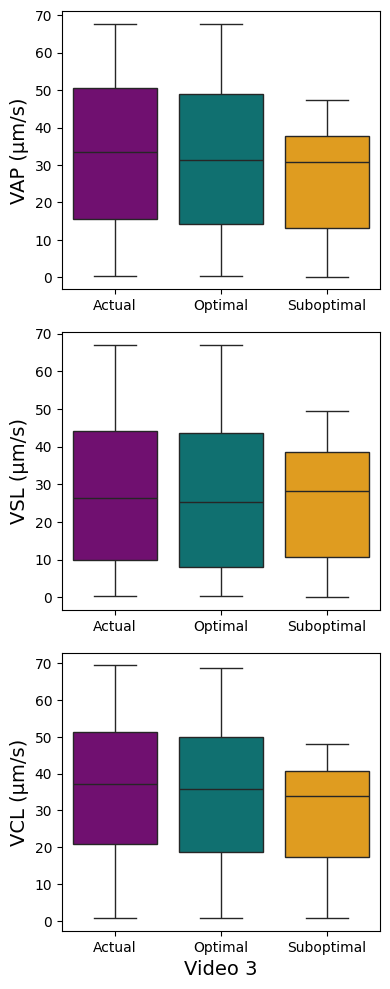

In [20]:
# Same plot, but with side by side box plots

pred_vap = pred.groupby('sperm').first()['VAP']
pred_vsl = pred.groupby('sperm').first()['VSL']
pred_vcl = pred.groupby('sperm').first()['VCL']
# pred_alh_mean = pred.groupby('sperm').first()['ALH_mean']
# pred_alh_max = pred.groupby('sperm').first()['ALH_max']
# pred_bcf = pred.groupby('sperm').first()['BCF']

gt_vap = gt.groupby('sperm').first()['VAP']
gt_vsl = gt.groupby('sperm').first()['VSL']
gt_vcl = gt.groupby('sperm').first()['VCL']
# gt_alh_mean = gt.groupby('sperm').first()['ALH_mean']
# gt_alh_max = gt.groupby('sperm').first()['ALH_max']
# gt_bcf = gt.groupby('sperm').first()['BCF']

subopt_vap = subopt.groupby('sperm').first()['VAP']
subopt_vsl = subopt.groupby('sperm').first()['VSL']
subopt_vcl = subopt.groupby('sperm').first()['VCL']
# subopt_alh_mean = subopt.groupby('sperm').first()['ALH_mean']
# subopt_alh_max = subopt.groupby('sperm').first()['ALH_max']
# subopt_bcf = subopt.groupby('sperm').first()['BCF']

import math
vap_max = math.ceil(max(pred_vap.max(), gt_vap.max(), subopt_vap.max()))
vsl_max = math.ceil(max(pred_vsl.max(), gt_vsl.max(), subopt_vsl.max()))
vcl_max = math.ceil(max(pred_vcl.max(), gt_vcl.max(), subopt_vcl.max()))
# alh_mean_max = math.ceil(max(pred_alh_mean.max(), gt_alh_mean.max(), subopt_alh_mean.max()))
# alh_max_max = math.ceil(max(pred_alh_max.max(), gt_alh_max.max(), subopt_alh_max.max()))
# bcf_max = math.ceil(max(pred_bcf.max(), gt_bcf.max(), subopt_bcf.max()))

# Create dataframe for box plots side-by-side with seaborn
import pandas as pd

# Concatenate the series for each method
df = pd.DataFrame({
    'Data': (['Actual'] * len(gt_vap)) + (['Optimal'] * len(pred_vap)) + (['Suboptimal'] * len(subopt_vap)),
    'VAP': pd.concat([gt_vap, pred_vap, subopt_vap], ignore_index=True),
    'VSL': pd.concat([gt_vsl, pred_vsl, subopt_vsl], ignore_index=True),
    'VCL': pd.concat([gt_vcl, pred_vcl, subopt_vcl], ignore_index=True),
    # 'ALH_mean': pd.concat([gt_alh_mean, pred_alh_mean, subopt_alh_mean], ignore_index=True),
    # 'ALH_max': pd.concat([gt_alh_max, pred_alh_max, subopt_alh_max], ignore_index=True),
    # 'BCF': pd.concat([gt_bcf, pred_bcf, subopt_bcf], ignore_index=True)
})

fig, axs = plt.subplots(3, 1, figsize=(4, 10))

import seaborn as sns
colors = {'Actual': 'purple', 'Optimal': 'teal', 'Suboptimal': 'orange'}
sns.boxplot(x="Data", y="VAP", hue="Data", data=df, palette=colors, ax=axs[0])
sns.boxplot(x="Data", y="VSL", hue="Data", data=df, palette=colors, ax=axs[1])
sns.boxplot(x="Data", y="VCL", hue="Data", data=df, palette=colors, ax=axs[2])

axs[0].set_ylabel("VAP (µm/s)", fontsize=14)
axs[1].set_ylabel("VSL (µm/s)", fontsize=14)
axs[2].set_ylabel("VCL (µm/s)", fontsize=14)

axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[2].set_xlabel("Video 3", fontsize=14)

plt.tight_layout()
plt.show()

fig.savefig("boxchart3.jpg", dpi=300)

In [ ]:
# # Transpose of the previous plot
# pred_vap = pred.groupby('sperm').first()['VAP']
# pred_vsl = pred.groupby('sperm').first()['VSL']
# pred_vcl = pred.groupby('sperm').first()['VCL']
# pred_alh_mean = pred.groupby('sperm').first()['ALH_mean']
# pred_alh_max = pred.groupby('sperm').first()['ALH_max']
# pred_bcf = pred.groupby('sperm').first()['BCF']

# gt_vap = gt.groupby('sperm').first()['VAP']
# gt_vsl = gt.groupby('sperm').first()['VSL']
# gt_vcl = gt.groupby('sperm').first()['VCL']
# gt_alh_mean = gt.groupby('sperm').first()['ALH_mean']
# gt_alh_max = gt.groupby('sperm').first()['ALH_max']
# gt_bcf = gt.groupby('sperm').first()['BCF']

# subopt_vap = subopt.groupby('sperm').first()['VAP']
# subopt_vsl = subopt.groupby('sperm').first()['VSL']
# subopt_vcl = subopt.groupby('sperm').first()['VCL']
# subopt_alh_mean = subopt.groupby('sperm').first()['ALH_mean']
# subopt_alh_max = subopt.groupby('sperm').first()['ALH_max']
# subopt_bcf = subopt.groupby('sperm').first()['BCF']

# # Create a figure with 6 rows and 3 columns
# fig, axs = plt.subplots(6, 3, figsize=(7, 14))

# import math
# vap_max = math.ceil(max(pred_vap.max(), gt_vap.max(), subopt_vap.max()))
# vsl_max = math.ceil(max(pred_vsl.max(), gt_vsl.max(), subopt_vsl.max()))
# vcl_max = math.ceil(max(pred_vcl.max(), gt_vcl.max(), subopt_vcl.max()))
# alh_mean_max = math.ceil(max(pred_alh_mean.max(), gt_alh_mean.max(), subopt_alh_mean.max()))
# alh_max_max = math.ceil(max(pred_alh_max.max(), gt_alh_max.max(), subopt_alh_max.max()))
# bcf_max = math.ceil(max(pred_bcf.max(), gt_bcf.max(), subopt_bcf.max()))

# # Create horizontal violin plots for each stat and each method
# axs[0, 0].violinplot(gt_vap, showmeans=True)
# axs[0, 0].set_title('Ground Truth VAP')
# axs[0, 1].violinplot(pred_vap, showmeans=True)
# axs[0, 1].set_title('Prediction VAP')
# axs[0, 2].violinplot(subopt_vap, showmeans=True)
# axs[0, 2].set_title('Suboptimal VAP')
# axs[1, 0].violinplot(gt_vsl, showmeans=True)
# axs[1, 0].set_title('Ground Truth VSL')
# axs[1, 1].violinplot(pred_vsl, showmeans=True)
# axs[1, 1].set_title('Prediction VSL')
# axs[1, 2].violinplot(subopt_vsl, showmeans=True)
# axs[1, 2].set_title('Suboptimal VSL')
# axs[2, 0].violinplot(gt_vcl, showmeans=True)
# axs[2, 0].set_title('Ground Truth VCL')
# axs[2, 1].violinplot(pred_vcl, showmeans=True)
# axs[2, 1].set_title('Prediction VCL')
# axs[2, 2].violinplot(subopt_vcl, showmeans=True)
# axs[2, 2].set_title('Suboptimal VCL')
# axs[3, 0].violinplot(gt_alh_mean, showmeans=True)
# axs[3, 0].set_title('Ground Truth ALH Mean')
# axs[3, 1].violinplot(pred_alh_mean, showmeans=True)
# axs[3, 1].set_title('Prediction ALH Mean')
# axs[3, 2].violinplot(subopt_alh_mean, showmeans=True)
# axs[3, 2].set_title('Suboptimal ALH Mean')
# axs[4, 0].violinplot(gt_alh_max, showmeans=True)
# axs[4, 0].set_title('Ground Truth ALH Max')
# axs[4, 1].violinplot(pred_alh_max, showmeans=True)
# axs[4, 1].set_title('Prediction ALH Max')
# axs[4, 2].violinplot(subopt_alh_max, showmeans=True)
# axs[4, 2].set_title('Suboptimal ALH Max')
# axs[5, 0].violinplot(gt_bcf, showmeans=True)
# axs[5, 0].set_title('Ground Truth BCF')
# axs[5, 1].violinplot(pred_bcf, showmeans=True)
# axs[5, 1].set_title('Prediction BCF')
# axs[5, 2].violinplot(subopt_bcf, showmeans=True)
# axs[5, 2].set_title('Suboptimal BCF')

# # Set y-limits for each subplot
# axs[0, 0].set_ylim(0, vap_max)
# axs[0, 1].set_ylim(0, vap_max)
# axs[0, 2].set_ylim(0, vap_max)
# axs[1, 0].set_ylim(0, vsl_max)
# axs[1, 1].set_ylim(0, vsl_max)
# axs[1, 2].set_ylim(0, vsl_max)
# axs[2, 0].set_ylim(0, vcl_max)
# axs[2, 1].set_ylim(0, vcl_max)
# axs[2, 2].set_ylim(0, vcl_max)
# axs[3, 0].set_ylim(0, alh_mean_max)
# axs[3, 1].set_ylim(0, alh_mean_max)
# axs[3, 2].set_ylim(0, alh_mean_max)
# axs[4, 0].set_ylim(0, alh_max_max)
# axs[4, 1].set_ylim(0, alh_max_max)
# axs[4, 2].set_ylim(0, alh_max_max)
# axs[5, 0].set_ylim(0, bcf_max)
# axs[5, 1].set_ylim(0, bcf_max)
# axs[5, 2].set_ylim(0, bcf_max)

# # Set colors of the bodies
# for ax in axs.flat:
#     for pc in ax.collections:
#         pc.set_facecolor('purple')
#         pc.set_edgecolor('black')
#         pc.set_alpha(0.7)

# # Set common axis labels
# for ax in axs[:,0]:
#     ax.set_ylabel('Value')
# for ax in axs[2,:]:
#     ax.set_xlabel('Frequency')  

# # Adjust layout
# plt.tight_layout()

# Build 3x6 subplot for each stat and each method

# pred_vap = pred.groupby('sperm').first()['VAP']
# pred_vsl = pred.groupby('sperm').first()['VSL']
# pred_vcl = pred.groupby('sperm').first()['VCL']
# pred_alh_mean = pred.groupby('sperm').first()['ALH_mean']
# pred_alh_max = pred.groupby('sperm').first()['ALH_max']
# pred_bcf = pred.groupby('sperm').first()['BCF']

# gt_vap = gt.groupby('sperm').first()['VAP']
# gt_vsl = gt.groupby('sperm').first()['VSL']
# gt_vcl = gt.groupby('sperm').first()['VCL']
# gt_alh_mean = gt.groupby('sperm').first()['ALH_mean']
# gt_alh_max = gt.groupby('sperm').first()['ALH_max']
# gt_bcf = gt.groupby('sperm').first()['BCF']

# subopt_vap = subopt.groupby('sperm').first()['VAP']
# subopt_vsl = subopt.groupby('sperm').first()['VSL']
# subopt_vcl = subopt.groupby('sperm').first()['VCL']
# subopt_alh_mean = subopt.groupby('sperm').first()['ALH_mean']
# subopt_alh_max = subopt.groupby('sperm').first()['ALH_max']
# subopt_bcf = subopt.groupby('sperm').first()['BCF']

# # Create a figure with 3 rows and 6 columns
# fig, axs = plt.subplots(3, 6, figsize=(18, 9))

# import math
# vap_max = math.ceil(max(pred_vap.max(), gt_vap.max(), subopt_vap.max()))
# vsl_max = math.ceil(max(pred_vsl.max(), gt_vsl.max(), subopt_vsl.max()))
# vcl_max = math.ceil(max(pred_vcl.max(), gt_vcl.max(), subopt_vcl.max()))
# alh_mean_max = math.ceil(max(pred_alh_mean.max(), gt_alh_mean.max(), subopt_alh_mean.max()))
# alh_max_max = math.ceil(max(pred_alh_max.max(), gt_alh_max.max(), subopt_alh_max.max()))
# bcf_max = math.ceil(max(pred_bcf.max(), gt_bcf.max(), subopt_bcf.max()))

# # Create horizontal violin plots for each stat and each method
# axs[0, 0].violinplot(gt_vap, vert=False, showmeans=True)
# axs[0, 0].set_title('Ground Truth VAP')
# axs[1, 0].violinplot(pred_vap, vert=False, showmeans=True)
# axs[1, 0].set_title('Prediction VAP')
# axs[2, 0].violinplot(subopt_vap, vert=False, showmeans=True)
# axs[2, 0].set_title('Suboptimal VAP')
# axs[0, 1].violinplot(gt_vsl, vert=False, showmeans=True)
# axs[0, 1].set_title('Ground Truth VSL')
# axs[1, 1].violinplot(pred_vsl, vert=False, showmeans=True)
# axs[1, 1].set_title('Prediction VSL')
# axs[2, 1].violinplot(subopt_vsl, vert=False, showmeans=True)
# axs[2, 1].set_title('Suboptimal VSL')
# axs[0, 2].violinplot(gt_vcl, vert=False, showmeans=True)
# axs[0, 2].set_title('Ground Truth VCL')
# axs[1, 2].violinplot(pred_vcl, vert=False, showmeans=True)
# axs[1, 2].set_title('Prediction VCL')
# axs[2, 2].violinplot(subopt_vcl, vert=False, showmeans=True)
# axs[2, 2].set_title('Suboptimal VCL')
# axs[0, 3].violinplot(gt_alh_mean, vert=False, showmeans=True)
# axs[0, 3].set_title('Ground Truth ALH Mean')
# axs[1, 3].violinplot(pred_alh_mean, vert=False, showmeans=True)
# axs[1, 3].set_title('Prediction ALH Mean')
# axs[2, 3].violinplot(subopt_alh_mean, vert=False, showmeans=True)
# axs[2, 3].set_title('Suboptimal ALH Mean')
# axs[0, 4].violinplot(gt_alh_max, vert=False, showmeans=True)
# axs[0, 4].set_title('Ground Truth ALH Max')
# axs[1, 4].violinplot(pred_alh_max, vert=False, showmeans=True)
# axs[1, 4].set_title('Prediction ALH Max')
# axs[2, 4].violinplot(subopt_alh_max, vert=False, showmeans=True)
# axs[2, 4].set_title('Suboptimal ALH Max')
# axs[0, 5].violinplot(gt_bcf, vert=False, showmeans=True)
# axs[0, 5].set_title('Ground Truth BCF')
# axs[1, 5].violinplot(pred_bcf, vert=False, showmeans=True)
# axs[1, 5].set_title('Prediction BCF')
# axs[2, 5].violinplot(subopt_bcf, vert=False, showmeans=True)
# axs[2, 5].set_title('Suboptimal BCF')

# # Set x-limits for each subplot
# axs[0, 0].set_xlim(0, vap_max)
# axs[1, 0].set_xlim(0, vap_max)
# axs[2, 0].set_xlim(0, vap_max)
# axs[0, 1].set_xlim(0, vsl_max)
# axs[1, 1].set_xlim(0, vsl_max)
# axs[2, 1].set_xlim(0, vsl_max)
# axs[0, 2].set_xlim(0, vcl_max)
# axs[1, 2].set_xlim(0, vcl_max)
# axs[2, 2].set_xlim(0, vcl_max)
# axs[0, 3].set_xlim(0, alh_mean_max)
# axs[1, 3].set_xlim(0, alh_mean_max)
# axs[2, 3].set_xlim(0, alh_mean_max)
# axs[0, 4].set_xlim(0, alh_max_max)
# axs[1, 4].set_xlim(0, alh_max_max)
# axs[2, 4].set_xlim(0, alh_max_max)
# axs[0, 5].set_xlim(0, bcf_max)
# axs[1, 5].set_xlim(0, bcf_max)
# axs[2, 5].set_xlim(0, bcf_max)

# # Set colors of the bodies
# for ax in axs.flat:
#     for pc in ax.collections:
#         pc.set_facecolor('purple')
#         pc.set_edgecolor('black')
#         pc.set_alpha(0.7)

# # Set common axis labels
# for ax in axs[:,0]:
#     ax.set_ylabel('Likelihood')
# for ax in axs[2,:]:
#     ax.set_xlabel('Value')  

# # Adjust layout
# plt.tight_layout()




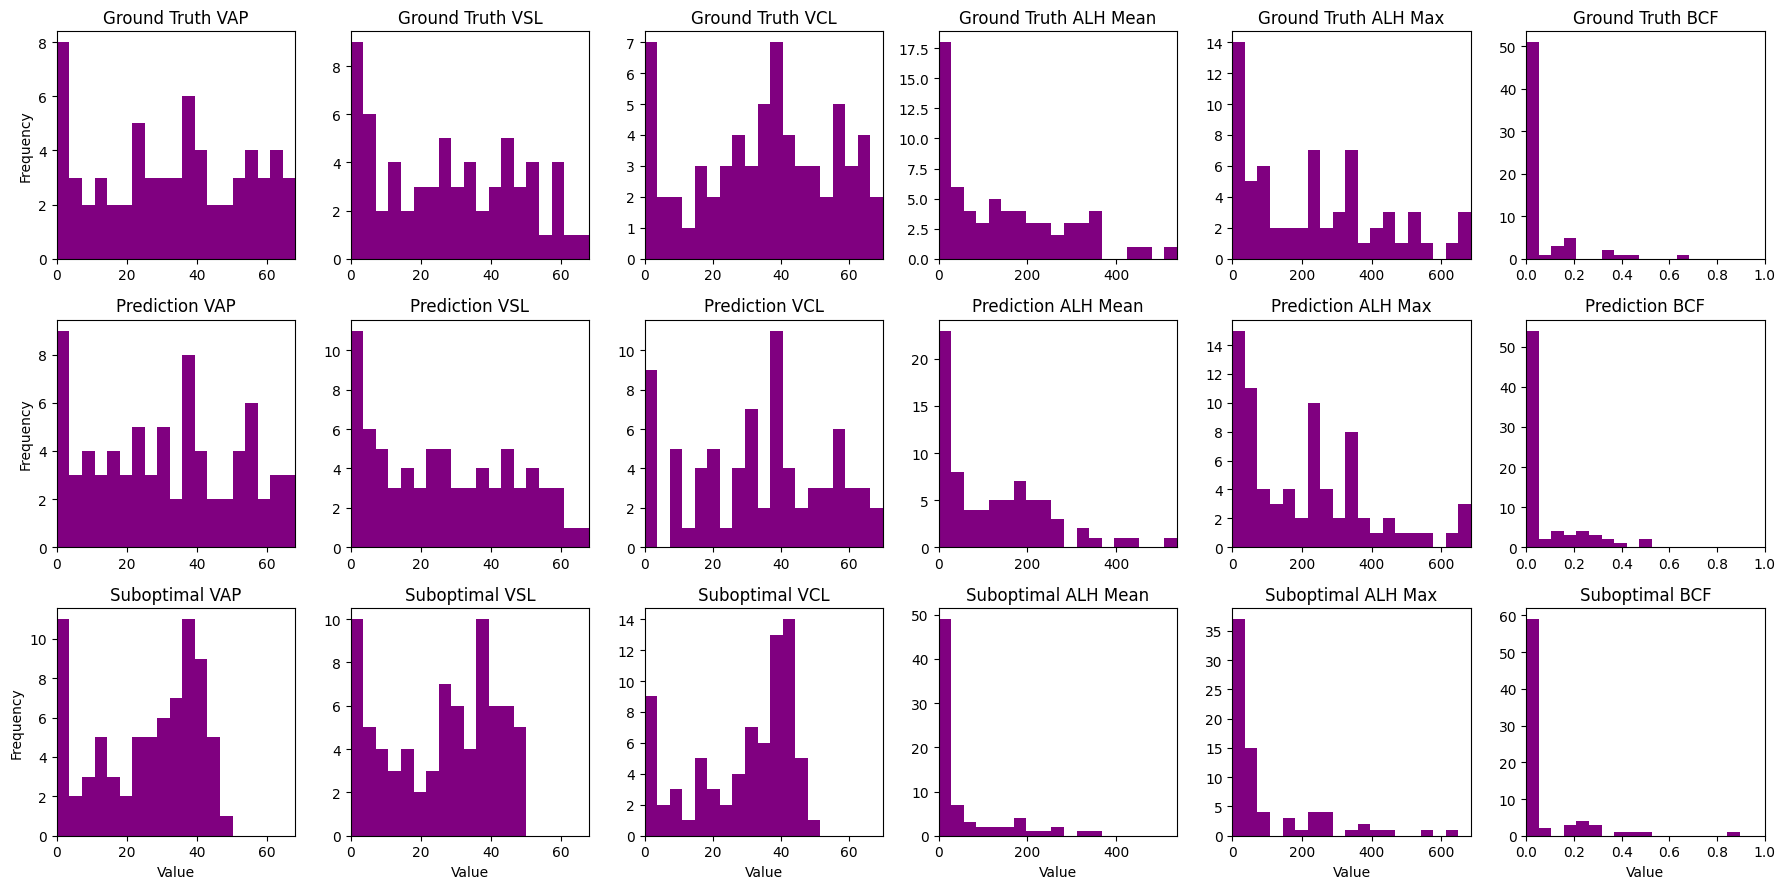

In [52]:
# Build 3x6 subplot for each stat and each method of histograms

pred_vap = pred.groupby('sperm').first()['VAP']
pred_vsl = pred.groupby('sperm').first()['VSL']
pred_vcl = pred.groupby('sperm').first()['VCL']
pred_alh_mean = pred.groupby('sperm').first()['ALH_mean']
pred_alh_max = pred.groupby('sperm').first()['ALH_max']
pred_bcf = pred.groupby('sperm').first()['BCF']

gt_vap = gt.groupby('sperm').first()['VAP']
gt_vsl = gt.groupby('sperm').first()['VSL']
gt_vcl = gt.groupby('sperm').first()['VCL']
gt_alh_mean = gt.groupby('sperm').first()['ALH_mean']
gt_alh_max = gt.groupby('sperm').first()['ALH_max']
gt_bcf = gt.groupby('sperm').first()['BCF']

subopt_vap = subopt.groupby('sperm').first()['VAP']
subopt_vsl = subopt.groupby('sperm').first()['VSL']
subopt_vcl = subopt.groupby('sperm').first()['VCL']
subopt_alh_mean = subopt.groupby('sperm').first()['ALH_mean']
subopt_alh_max = subopt.groupby('sperm').first()['ALH_max']
subopt_bcf = subopt.groupby('sperm').first()['BCF']

# Create a figure with 3 rows and 6 columns
fig, axs = plt.subplots(3, 6, figsize=(18, 9))

import math
vap_max = math.ceil(max(pred_vap.max(), gt_vap.max(), subopt_vap.max()))
vsl_max = math.ceil(max(pred_vsl.max(), gt_vsl.max(), subopt_vsl.max()))
vcl_max = math.ceil(max(pred_vcl.max(), gt_vcl.max(), subopt_vcl.max()))
alh_mean_max = math.ceil(max(pred_alh_mean.max(), gt_alh_mean.max(), subopt_alh_mean.max()))
alh_max_max = math.ceil(max(pred_alh_max.max(), gt_alh_max.max(), subopt_alh_max.max()))
bcf_max = math.ceil(max(pred_bcf.max(), gt_bcf.max(), subopt_bcf.max()))

# Create bins for each histogram for each stat
vap_bins = np.linspace(0, vap_max, 20)
vsl_bins = np.linspace(0, vsl_max, 20)
vcl_bins = np.linspace(0, vcl_max, 20)
alh_mean_bins = np.linspace(0, alh_mean_max, 20)
alh_max_bins = np.linspace(0, alh_max_max, 20)
bcf_bins = np.linspace(0, bcf_max, 20)

# Create horizontal violin plots for each stat and each method
axs[0, 0].hist(gt_vap, bins=vap_bins, color='purple', alpha=1.0)
axs[0, 0].set_title('Ground Truth VAP')
axs[1, 0].hist(pred_vap, bins=vap_bins, color='purple', alpha=1.0)
axs[1, 0].set_title('Prediction VAP')
axs[2, 0].hist(subopt_vap, bins=vap_bins, color='purple', alpha=1.0)
axs[2, 0].set_title('Suboptimal VAP')
axs[0, 1].hist(gt_vsl, bins=vsl_bins, color='purple', alpha=1.0)
axs[0, 1].set_title('Ground Truth VSL')
axs[1, 1].hist(pred_vsl, bins=vsl_bins, color='purple', alpha=1.0)
axs[1, 1].set_title('Prediction VSL')
axs[2, 1].hist(subopt_vsl, bins=vsl_bins, color='purple', alpha=1.0)
axs[2, 1].set_title('Suboptimal VSL')
axs[0, 2].hist(gt_vcl, bins=vcl_bins, color='purple', alpha=1.0)
axs[0, 2].set_title('Ground Truth VCL')
axs[1, 2].hist(pred_vcl, bins=vcl_bins, color='purple', alpha=1.0)
axs[1, 2].set_title('Prediction VCL')
axs[2, 2].hist(subopt_vcl, bins=vcl_bins, color='purple', alpha=1.0)
axs[2, 2].set_title('Suboptimal VCL')
axs[0, 3].hist(gt_alh_mean, bins=alh_mean_bins, color='purple', alpha=1.0)
axs[0, 3].set_title('Ground Truth ALH Mean')
axs[1, 3].hist(pred_alh_mean, bins=alh_mean_bins, color='purple', alpha=1.0)
axs[1, 3].set_title('Prediction ALH Mean')
axs[2, 3].hist(subopt_alh_mean, bins=alh_mean_bins, color='purple', alpha=1.0)
axs[2, 3].set_title('Suboptimal ALH Mean')
axs[0, 4].hist(gt_alh_max, bins=alh_max_bins, color='purple', alpha=1.0)
axs[0, 4].set_title('Ground Truth ALH Max')
axs[1, 4].hist(pred_alh_max, bins=alh_max_bins, color='purple', alpha=1.0)
axs[1, 4].set_title('Prediction ALH Max')
axs[2, 4].hist(subopt_alh_max, bins=alh_max_bins, color='purple', alpha=1.0)
axs[2, 4].set_title('Suboptimal ALH Max')
axs[0, 5].hist(gt_bcf, bins=bcf_bins, color='purple', alpha=1.0)
axs[0, 5].set_title('Ground Truth BCF')
axs[1, 5].hist(pred_bcf, bins=bcf_bins, color='purple', alpha=1.0)
axs[1, 5].set_title('Prediction BCF')
axs[2, 5].hist(subopt_bcf, bins=bcf_bins, color='purple', alpha=1.0)
axs[2, 5].set_title('Suboptimal BCF')

# Set x-limits for each subplot
axs[0, 0].set_xlim(0, vap_max)
axs[1, 0].set_xlim(0, vap_max)
axs[2, 0].set_xlim(0, vap_max)
axs[0, 1].set_xlim(0, vsl_max)
axs[1, 1].set_xlim(0, vsl_max)
axs[2, 1].set_xlim(0, vsl_max)
axs[0, 2].set_xlim(0, vcl_max)
axs[1, 2].set_xlim(0, vcl_max)
axs[2, 2].set_xlim(0, vcl_max)
axs[0, 3].set_xlim(0, alh_mean_max)
axs[1, 3].set_xlim(0, alh_mean_max)
axs[2, 3].set_xlim(0, alh_mean_max)
axs[0, 4].set_xlim(0, alh_max_max)
axs[1, 4].set_xlim(0, alh_max_max)
axs[2, 4].set_xlim(0, alh_max_max)
axs[0, 5].set_xlim(0, bcf_max)
axs[1, 5].set_xlim(0, bcf_max)
axs[2, 5].set_xlim(0, bcf_max)

# Set common axis labels
for ax in axs[:,0]:
    ax.set_ylabel('Frequency')
for ax in axs[2,:]:
    ax.set_xlabel('Value')  

# Adjust layout
plt.tight_layout()

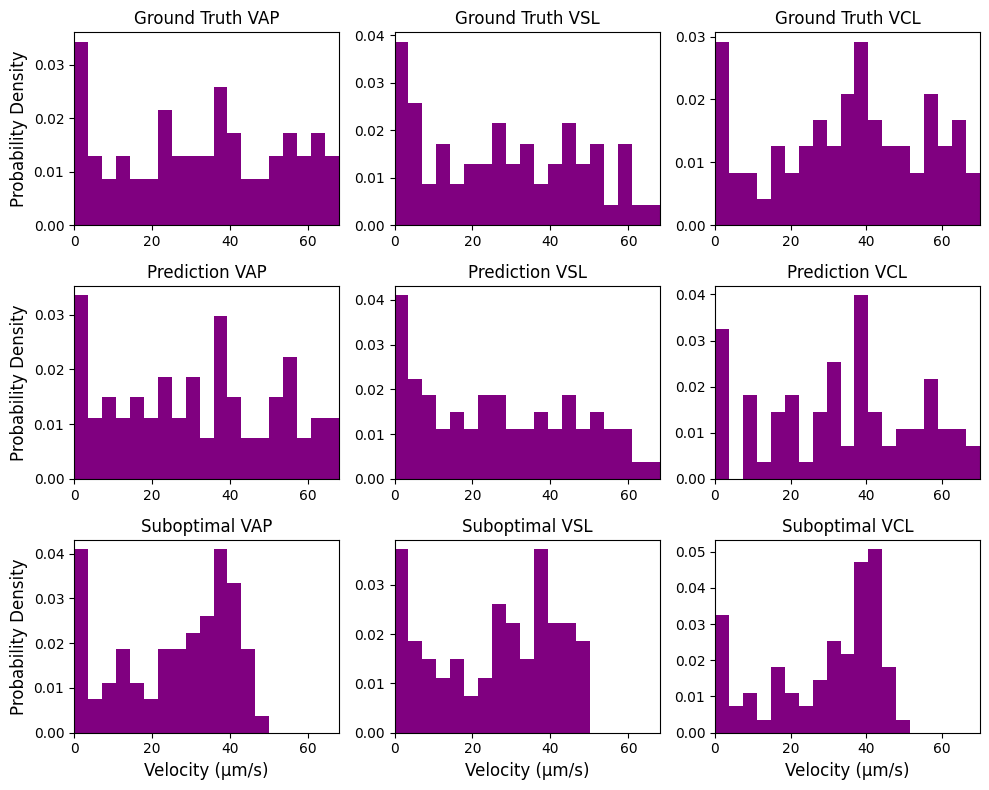

In [55]:
# Final Version for Paper

# Build 3x3 subplot for each stat and each method of histograms

pred_vap = pred.groupby('sperm').first()['VAP']
pred_vsl = pred.groupby('sperm').first()['VSL']
pred_vcl = pred.groupby('sperm').first()['VCL']

gt_vap = gt.groupby('sperm').first()['VAP']
gt_vsl = gt.groupby('sperm').first()['VSL']
gt_vcl = gt.groupby('sperm').first()['VCL']

subopt_vap = subopt.groupby('sperm').first()['VAP']
subopt_vsl = subopt.groupby('sperm').first()['VSL']
subopt_vcl = subopt.groupby('sperm').first()['VCL']


# Create a figure with 3 rows and 3 columns
fig, axs = plt.subplots(3, 3, figsize=(10, 8))

import math
vap_max = math.ceil(max(pred_vap.max(), gt_vap.max(), subopt_vap.max()))
vsl_max = math.ceil(max(pred_vsl.max(), gt_vsl.max(), subopt_vsl.max()))
vcl_max = math.ceil(max(pred_vcl.max(), gt_vcl.max(), subopt_vcl.max()))

# Create bins for each histogram for each stat
vap_bins = np.linspace(0, vap_max, 20)
vsl_bins = np.linspace(0, vsl_max, 20)
vcl_bins = np.linspace(0, vcl_max, 20)

# Create horizontal violin plots for each stat and each method
axs[0, 0].hist(gt_vap, bins=vap_bins, color='purple', alpha=1.0, density=True)
axs[0, 0].set_title('Ground Truth VAP')
axs[1, 0].hist(pred_vap, bins=vap_bins, color='purple', alpha=1.0, density=True)
axs[1, 0].set_title('Prediction VAP')
axs[2, 0].hist(subopt_vap, bins=vap_bins, color='purple', alpha=1.0, density=True)
axs[2, 0].set_title('Suboptimal VAP')
axs[0, 1].hist(gt_vsl, bins=vsl_bins, color='purple', alpha=1.0, density=True)
axs[0, 1].set_title('Ground Truth VSL')
axs[1, 1].hist(pred_vsl, bins=vsl_bins, color='purple', alpha=1.0, density=True)
axs[1, 1].set_title('Prediction VSL')
axs[2, 1].hist(subopt_vsl, bins=vsl_bins, color='purple', alpha=1.0, density=True)
axs[2, 1].set_title('Suboptimal VSL')
axs[0, 2].hist(gt_vcl, bins=vcl_bins, color='purple', alpha=1.0, density=True)
axs[0, 2].set_title('Ground Truth VCL')
axs[1, 2].hist(pred_vcl, bins=vcl_bins, color='purple', alpha=1.0, density=True)
axs[1, 2].set_title('Prediction VCL')
axs[2, 2].hist(subopt_vcl, bins=vcl_bins, color='purple', alpha=1.0, density=True)
axs[2, 2].set_title('Suboptimal VCL')

# Set x-limits for each subplot
axs[0, 0].set_xlim(0, vap_max)
axs[1, 0].set_xlim(0, vap_max)
axs[2, 0].set_xlim(0, vap_max)
axs[0, 1].set_xlim(0, vsl_max)
axs[1, 1].set_xlim(0, vsl_max)
axs[2, 1].set_xlim(0, vsl_max)
axs[0, 2].set_xlim(0, vcl_max)
axs[1, 2].set_xlim(0, vcl_max)
axs[2, 2].set_xlim(0, vcl_max)

# Set common axis labels
for ax in axs[:,0]:
    ax.set_ylabel('Probability Density', fontsize=12)
for ax in axs[2,:]:
    ax.set_xlabel('Velocity (µm/s)', fontsize=12)

# Adjust layout
plt.tight_layout()

## Experiment 1

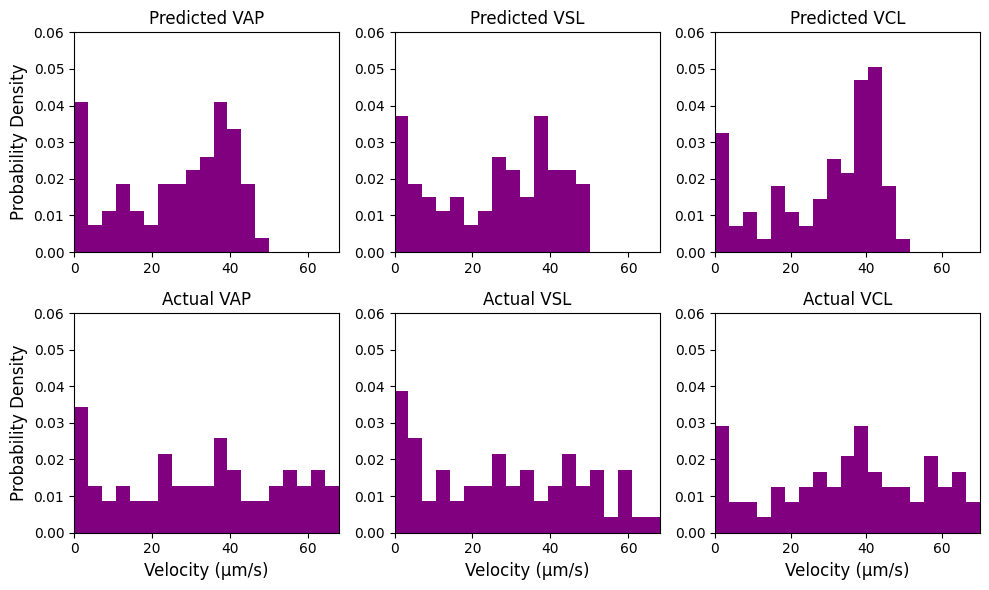

In [95]:
# Final Version for Paper
# Build 2x3 subplot for each stat and each method of histograms

gt_vap = gt.groupby('sperm').first()['VAP']
gt_vsl = gt.groupby('sperm').first()['VSL']
gt_vcl = gt.groupby('sperm').first()['VCL']

subopt_vap = subopt.groupby('sperm').first()['VAP']
subopt_vsl = subopt.groupby('sperm').first()['VSL']
subopt_vcl = subopt.groupby('sperm').first()['VCL']


# Create a figure with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

import math
vap_max = math.ceil(max(pred_vap.max(), gt_vap.max(), subopt_vap.max()))
vsl_max = math.ceil(max(pred_vsl.max(), gt_vsl.max(), subopt_vsl.max()))
vcl_max = math.ceil(max(pred_vcl.max(), gt_vcl.max(), subopt_vcl.max()))

# Create bins for each histogram for each stat
vap_bins = np.linspace(0, vap_max, 20)
vsl_bins = np.linspace(0, vsl_max, 20)
vcl_bins = np.linspace(0, vcl_max, 20)

# Create horizontal violin plots for each stat and each method
axs[1, 0].hist(gt_vap, bins=vap_bins, color='purple', alpha=1.0, density=True)
axs[1, 0].set_title('Actual VAP')
axs[0, 0].hist(subopt_vap, bins=vap_bins, color='purple', alpha=1.0, density=True)
axs[0, 0].set_title('Predicted VAP')
axs[1, 1].hist(gt_vsl, bins=vsl_bins, color='purple', alpha=1.0, density=True)
axs[1, 1].set_title('Actual VSL')
axs[0, 1].hist(subopt_vsl, bins=vsl_bins, color='purple', alpha=1.0, density=True)
axs[0, 1].set_title('Predicted VSL')
axs[1, 2].hist(gt_vcl, bins=vcl_bins, color='purple', alpha=1.0, density=True)
axs[1, 2].set_title('Actual VCL')
axs[0, 2].hist(subopt_vcl, bins=vcl_bins, color='purple', alpha=1.0, density=True)
axs[0, 2].set_title('Predicted VCL')

# Set x-limits for each subplot
axs[0, 0].set_xlim(0, vap_max)
axs[1, 0].set_xlim(0, vap_max)
axs[0, 1].set_xlim(0, vsl_max)
axs[1, 1].set_xlim(0, vsl_max)
axs[0, 2].set_xlim(0, vcl_max)
axs[1, 2].set_xlim(0, vcl_max)

axs[0, 0].set_ylim(0, 0.06)
axs[1, 0].set_ylim(0, 0.06)
axs[0, 1].set_ylim(0, 0.06)
axs[1, 1].set_ylim(0, 0.06)
axs[0, 2].set_ylim(0, 0.06)
axs[1, 2].set_ylim(0, 0.06)

# Set common axis labels
for ax in axs[:,0]:
    ax.set_ylabel('Probability Density', fontsize=12)
for ax in axs[1,:]:
    ax.set_xlabel('Velocity (µm/s)', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.savefig("experiment1.pdf", dpi=300)

In [54]:
# import matplotlib.pyplot as plt

# # Generate historgrams for VSL, VCL, and VAP
# def plotStat(data,stat="VAP",method="gt",fs = 24):

#     # Get unique sperm
#     sperm_ids = data['sperm'].unique()

#     # Get first stat values for each sperm id
#     first_values = data.groupby('sperm').first()[stat]

#     plt.hist(first_values, bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], alpha=1.0, color='purple')
#     plt.xlabel(stat + " (microns/second)",fontsize=fs)
#     xticks = [0,5,10,15,20]
#     plt.xticks(xticks, xticks, fontsize=fs)
#     plt.ylabel('Frequency', fontsize=fs)
#     yticks = [0,5,10,15]
#     plt.yticks(yticks, yticks, fontsize=fs)
#     #plt.title(f'{stat} Distribution')
#     #plt.legend()
#     plt.tight_layout()
#     plt.savefig(f'{stat}_distribution_{method}.pdf')
#     plt.show()

# plotStat(gt,stat="VAP")
# plotStat(pred,stat="VAP")
# plotStat(subopt,stat="VAP")

# plotStat(gt,stat="VSL")
# plotStat(pred,stat="VSL")
# plotStat(subopt,stat="VSL")

# plotStat(gt,stat="VCL")
# plotStat(pred,stat="VCL")
# plotStat(subopt,stat="VCL")



## Experiment 2

In [19]:
groundtruth = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_corrected.csv"
videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1.mp4"

#groundtruth = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1_corrected.csv"
#videofile = "Comparisons/10X Ph- 9Fps Wash Dil 1 16 P017me R1.mp4"

#groundtruth = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_corrected.csv"
#videofile = "Comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1.mp4"

# Load as Pandas DataFrame
gt_src = utils.loadDataFrame(groundtruth)

# Drop duplicates, interpolate, and filter sperm
gt_dd = utils.dropDuplicates(gt_src)

gt = utils.interpolateTracks(gt_dd)

gt = metrics.filterSperm(gt)

In [20]:
# Make versions of the DataFrames with only the 2 seconds (18 frames) of each sperm
gt_2s = gt[gt['frame'] < 18]

In [81]:
# Compute stats for each file
ps = 1/1.0476   # pixel size in micrometers
fps = 9    # frames per second
gt = stats.computeAllStats(gt,fps=fps,pixel_size=ps,interpolate=False)

gt_2s = stats.computeAllStats(gt_2s,fps=fps,pixel_size=ps,interpolate=False)

In [82]:
# Compute earth movers distance between distributions
import pandas as pd
from scipy.stats import wasserstein_distance

emd_df = pd.DataFrame({"Method": ["GT_2s"], "VAP": [None], "VSL": [None], "VCL": [None], "ALH_mean": [None], "ALH_max": [None], "BCF": [None]})

# Compute EMD for each statistic
for stat in ["VAP", "VSL", "VCL", "ALH_mean", "ALH_max", "BCF"]:
    emd_df.loc[0, stat] = wasserstein_distance(gt[stat], gt_2s[stat])

# Print the EMD DataFrame
print(emd_df)

  Method       VAP       VSL       VCL ALH_mean ALH_max       BCF
0  GT_2s  1.935011  6.211993  3.275602      NaN     NaN  0.092471


In [83]:
#print(pred.head())


# Print maxes of each stat for each file as a dataframe
summary_df = pd.DataFrame({
    'Stat': ['VAP', 'VSL', 'VCL', 'ALH_mean', 'ALH_max', 'BCF'],
    'Ground Truth': [gt['VAP'].max(), gt['VSL'].max(), gt['VCL'].max(), gt['ALH_mean'].max(), gt['ALH_max'].max(), gt['BCF'].max()],
    'GT_2s': [gt_2s['VAP'].max(), gt_2s['VSL'].max(), gt_2s['VCL'].max(), gt_2s['ALH_mean'].max(), gt_2s['ALH_max'].max(), gt_2s['BCF'].max()]
})

print(summary_df)

print("Mins:",gt["VAP"].min(), gt["VSL"].min(), gt["VCL"].min(), gt["ALH_mean"].min(), gt["ALH_max"].min(), gt["BCF"].min())


       Stat  Ground Truth      GT_2s
0       VAP     67.673850  69.089596
1       VSL     67.068163  73.510999
2       VCL     69.436975  70.136561
3  ALH_mean    535.784650  16.049464
4   ALH_max    683.607445  18.076059
5       BCF      0.671053   1.384615
Mins: 0.31940112149714167 0.39508461477857126 0.8563084800252527 3.1664149720585253 3.2001136833789587 0.0


In [87]:
# # Build 3x6 subplot for each stat and each method

# gt_vap = gt.groupby('sperm').first()['VAP']
# gt_vsl = gt.groupby('sperm').first()['VSL']
# gt_vcl = gt.groupby('sperm').first()['VCL']
# gt_alh_mean = gt.groupby('sperm').first()['ALH_mean']
# gt_alh_max = gt.groupby('sperm').first()['ALH_max']
# gt_bcf = gt.groupby('sperm').first()['BCF']

# gt_2s_vap = gt_2s.groupby('sperm').first()['VAP']
# gt_2s_vsl = gt_2s.groupby('sperm').first()['VSL']
# gt_2s_vcl = gt_2s.groupby('sperm').first()['VCL']
# gt_2s_alh_mean = gt_2s.groupby('sperm').first()['ALH_mean']
# gt_2s_alh_max = gt_2s.groupby('sperm').first()['ALH_max']
# gt_2s_bcf = gt_2s.groupby('sperm').first()['BCF']

# # Create a figure with 2 rows and 6 columns
# fig, axs = plt.subplots(2, 6, figsize=(18, 9))

# import math
# vap_max = math.ceil(max(gt_vap.max(), gt_2s_vap.max()))
# vsl_max = math.ceil(max(gt_vsl.max(), gt_2s_vsl.max()))
# vcl_max = math.ceil(max(gt_vcl.max(), gt_2s_vcl.max()))
# alh_mean_max = math.ceil(max(gt_alh_mean.max(), gt_2s_alh_mean.max()))
# alh_max_max = math.ceil(max(gt_alh_max.max(), gt_2s_alh_max.max()))
# bcf_max = math.ceil(max(gt_bcf.max(), gt_2s_bcf.max()))

# # Create horizontal violin plots for each stat and each method
# axs[0, 0].violinplot(gt_vap, vert=False, showmeans=True)
# axs[0, 0].set_title('Ground Truth VAP')
# axs[1, 0].violinplot(gt_2s_vap, vert=False, showmeans=True)
# axs[1, 0].set_title('GT_2s VAP')
# axs[0, 1].violinplot(gt_vsl, vert=False, showmeans=True)
# axs[0, 1].set_title('Ground Truth VSL')
# axs[1, 1].violinplot(gt_2s_vsl, vert=False, showmeans=True)
# axs[1, 1].set_title('GT_2s VSL')
# axs[0, 2].violinplot(gt_vcl, vert=False, showmeans=True)
# axs[0, 2].set_title('Ground Truth VCL')
# axs[1, 2].violinplot(gt_2s_vcl, vert=False, showmeans=True)
# axs[1, 2].set_title('GT_2s VCL')
# axs[0, 3].violinplot(gt_alh_mean, vert=False, showmeans=True)
# axs[0, 3].set_title('Ground Truth ALH Mean')
# axs[1, 3].violinplot(gt_2s_alh_mean, vert=False, showmeans=True)
# axs[1, 3].set_title('GT_2s ALH Mean')
# axs[0, 4].violinplot(gt_alh_max, vert=False, showmeans=True)
# axs[0, 4].set_title('Ground Truth ALH Max')
# axs[1, 4].violinplot(gt_2s_alh_max, vert=False, showmeans=True)
# axs[1, 4].set_title('GT_2s ALH Max')
# axs[0, 5].violinplot(gt_bcf, vert=False, showmeans=True)
# axs[0, 5].set_title('Ground Truth BCF')
# axs[1, 5].violinplot(gt_2s_bcf, vert=False, showmeans=True)
# axs[1, 5].set_title('GT_2s BCF')

# # Set x-limits for each subplot
# axs[0, 0].set_xlim(0, vap_max)
# axs[1, 0].set_xlim(0, vap_max)
# axs[0, 1].set_xlim(0, vsl_max)
# axs[1, 1].set_xlim(0, vsl_max)
# axs[0, 2].set_xlim(0, vcl_max)
# axs[1, 2].set_xlim(0, vcl_max)
# axs[0, 3].set_xlim(0, alh_mean_max)
# axs[1, 3].set_xlim(0, alh_mean_max)
# axs[0, 4].set_xlim(0, alh_max_max)
# axs[1, 4].set_xlim(0, alh_max_max)
# axs[0, 5].set_xlim(0, bcf_max)
# axs[1, 5].set_xlim(0, bcf_max)

# # Set colors of the bodies
# for ax in axs.flat:
#     for pc in ax.collections:
#         pc.set_facecolor('purple')
#         pc.set_edgecolor('black')
#         pc.set_alpha(0.7)

# # Set common axis labels
# for ax in axs[:,0]:
#     ax.set_ylabel('Likelihood')
# for ax in axs[1,:]:
#     ax.set_xlabel('Value')  

# # Adjust layout
# plt.tight_layout()



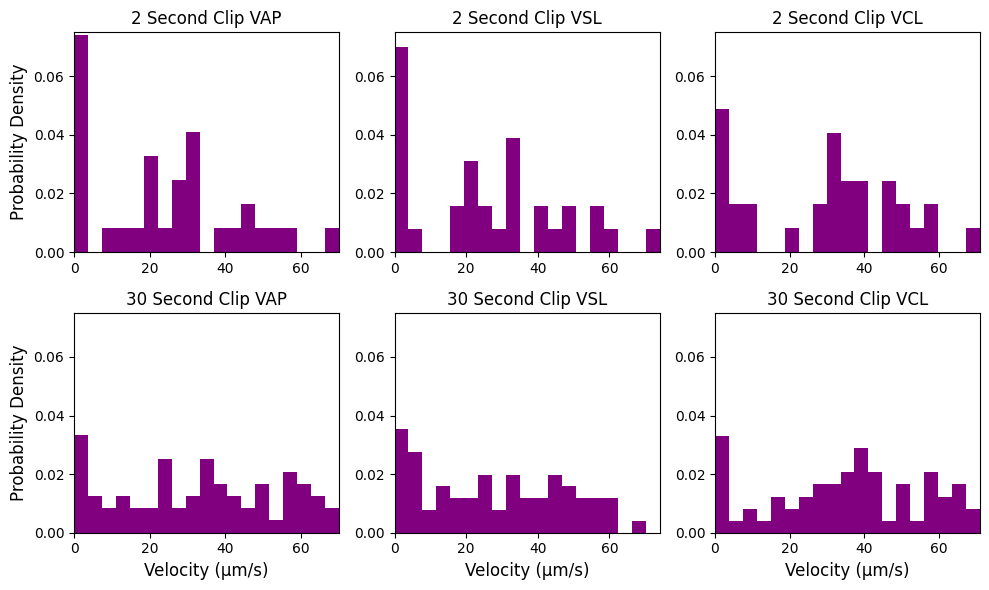

In [91]:
# Build 3x6 subplot for each stat and each method

gt_vap = gt.groupby('sperm').first()['VAP']
gt_vsl = gt.groupby('sperm').first()['VSL']
gt_vcl = gt.groupby('sperm').first()['VCL']

gt_2s_vap = gt_2s.groupby('sperm').first()['VAP']
gt_2s_vsl = gt_2s.groupby('sperm').first()['VSL']
gt_2s_vcl = gt_2s.groupby('sperm').first()['VCL']

# Create a figure with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

import math
vap_max = math.ceil(max(gt_vap.max(), gt_2s_vap.max()))
vsl_max = math.ceil(max(gt_vsl.max(), gt_2s_vsl.max()))
vcl_max = math.ceil(max(gt_vcl.max(), gt_2s_vcl.max()))

# Create horizontal violin plots for each stat and each method
# axs[0, 0].violinplot(gt_vap, vert=False, showmeans=True)
# axs[0, 0].set_title('Ground Truth VAP')
# axs[1, 0].violinplot(gt_2s_vap, vert=False, showmeans=True)
# axs[1, 0].set_title('GT_2s VAP')
# axs[0, 1].violinplot(gt_vsl, vert=False, showmeans=True)
# axs[0, 1].set_title('Ground Truth VSL')
# axs[1, 1].violinplot(gt_2s_vsl, vert=False, showmeans=True)
# axs[1, 1].set_title('GT_2s VSL')
# axs[0, 2].violinplot(gt_vcl, vert=False, showmeans=True)
# axs[0, 2].set_title('Ground Truth VCL')
# axs[1, 2].violinplot(gt_2s_vcl, vert=False, showmeans=True)
# axs[1, 2].set_title('GT_2s VCL')

# Create bins for each histogram for each stat
vap_bins = np.linspace(0, vap_max, 20)
vsl_bins = np.linspace(0, vsl_max, 20)
vcl_bins = np.linspace(0, vcl_max, 20)

# Create histograms for each stat and each method
axs[1, 0].hist(gt_vap, bins=vap_bins, color='purple', alpha=1.0, density=True)
axs[1, 0].set_title('30 Second Clip VAP')
axs[0, 0].hist(gt_2s_vap, bins=vap_bins, color='purple', alpha=1.0, density=True)
axs[0, 0].set_title('2 Second Clip VAP')
axs[1, 1].hist(gt_vsl, bins=vsl_bins, color='purple', alpha=1.0, density=True)
axs[1, 1].set_title('30 Second Clip VSL')
axs[0, 1].hist(gt_2s_vsl, bins=vsl_bins, color='purple', alpha=1.0, density=True)
axs[0, 1].set_title('2 Second Clip VSL')
axs[1, 2].hist(gt_vcl, bins=vcl_bins, color='purple', alpha=1.0, density=True)
axs[1, 2].set_title('30 Second Clip VCL')
axs[0, 2].hist(gt_2s_vcl, bins=vcl_bins, color='purple', alpha=1.0, density=True)
axs[0, 2].set_title('2 Second Clip VCL')


# Set x-limits for each subplot
axs[0, 0].set_xlim(0, vap_max)
axs[1, 0].set_xlim(0, vap_max)
axs[0, 1].set_xlim(0, vsl_max)
axs[1, 1].set_xlim(0, vsl_max)
axs[0, 2].set_xlim(0, vcl_max)
axs[1, 2].set_xlim(0, vcl_max)

axs[0, 0].set_ylim(0, 0.075)
axs[1, 0].set_ylim(0, 0.075)
axs[0, 1].set_ylim(0, 0.075)
axs[1, 1].set_ylim(0, 0.075)
axs[0, 2].set_ylim(0, 0.075)
axs[1, 2].set_ylim(0, 0.075)


# # Set colors of the bodies
# for ax in axs.flat:
#     for pc in ax.collections:
#         pc.set_facecolor('purple')
#         pc.set_edgecolor('black')
#         pc.set_alpha(0.7)

# Set common axis labels
for ax in axs[:,0]:
    ax.set_ylabel('Probability Density', fontsize=12)
for ax in axs[1,:]:
    ax.set_xlabel('Velocity (µm/s)', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.savefig("experiment2.pdf", dpi=300)
